# Example: Dynamic Delta Neutral Hedging to Compensate for Price Fluctuations
[Delta hedging](https://en.wikipedia.org/wiki/Delta_neutral) is a strategy used in options trading to minimize the risk associated with price movements in the underlying asset. This approach involves using other options contracts or shares of the underlying asset to achieve a delta-neutral position, i.e., eliminating the directional bias of the position.
* __Scenario 1__: You are long a `TSLA` put option (thus, you are short the shares) and are concerned about how the price movement of `TSLA` shares influences the overall risk of your position. Toward this risk, let's explore constructing a delta-neutral hedge.
* __Scenario 2__: You are short a `TSLA` call option (thus, you are also short the shares) and are concerned about how the price movement of `TSLA` shares influences the overall risk of your position. Toward this risk, let's explore constructing a delta-neutral hedge.

Both scenarios (s) 1 and 2 make the same directional assumption, namely, that `TSLA` shares will decline in price, i.e., you are `bearish` on `TSLA.` Let's explore how delta-neutral hedging would work for these scenarios.

## Learning objectives
Fill me in.

## Setup
Set up the computational environment by including the `Include.jl` file. The `Include.jl` file loads external packages, various functions we will use in the exercise, and custom types to model the components of our example problem.
* For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

In [3]:
include("Include.jl")

    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
   Resolving package versions...
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-134/module-4/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-134/module-4/Manifest.toml`
  Activating project at `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-134/module-4`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-134/module-4/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-134/module-4/Manifest.toml`
    Updating registry at `~/.julia/registries/General.toml`
    Updating git-repo `https://github.com/varnerlab/VLQuantitativeFinancePackage.jl.git`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CHEME-134/module-4/Project.toml`
  No Changes to `~/Desktop/julia_work/CHEME-130-eCornell-Repository/courses/CH

## Prerequisites
Fill me in

### Constants

In [87]:
Δt = (1/390)*(1/252); # 1-min
number_of_trading_periods = 60; # How many trading periods will we simulate?
number_of_samples = 1000; # number of samples to generate 
T = number_of_trading_periods*Δt; # Duration of trading periods in years
Sₒ = 261.49; # TSLA share price
IVₒ = 0.627397; # IV for K = 210 put with 60-DTE
β = 2.32; # TSLA 5y monthly beta value 06-25-24

Fill me in

In [8]:
option_dataset = load(joinpath(_PATH_TO_DATA, "TSLA-today-2023-06-19-exp-2023-08-18-dte-60d.jld2")) |> file -> file["data"];

In [9]:
option_dataset[50]

Dict{String, Any} with 9 entries:
  "day"                => Dict{String, Any}("change"=>0, "high"=>6.7, "change_p…
  "details"            => Dict{String, Any}("contract_type"=>"put", "ticker"=>"…
  "last_quote"         => Dict{String, Any}("midpoint"=>6.125, "ask"=>6.2, "tim…
  "last_trade"         => Dict{String, Any}("timeframe"=>"REAL-TIME", "exchange…
  "underlying_asset"   => Dict{String, Any}("timeframe"=>"REAL-TIME", "ticker"=…
  "greeks"             => Dict{String, Any}("theta"=>-0.126845, "gamma"=>0.0036…
  "open_interest"      => 3898
  "implied_volatility" => 0.627397
  "break_even_price"   => 203.875

One-minute aggregate data for `TSLA` and `VIX` for 2023

In [63]:
underlying_price_data_df = CSV.read(joinpath(_PATH_TO_DATA, "TSLA-OHLC-1-min-aggregate-2023.csv"), DataFrame);
volatility_data_df = CSV.read(joinpath(_PATH_TO_DATA, "VIX-OHLC-1-min-aggregate-2023.csv"), DataFrame);

Compute the vwap, and the log_growth_matrix 

In [13]:
growth_rate_array = vwap(underlying_price_data_df) |> data -> log_growth_matrix(data, Δt = Δt);

Compute (u,d,p) parameters from data assuming a real-world probability measure

In [15]:
(ū,d̄,p̄) = (RealWorldBinomialProbabilityMeasure())(growth_rate_array; Δt = Δt);

## Task 1: Construct and Sample Future Market States
Fill me in.

### TODO: Sample Discrete Tree of Future Share Prices

In [18]:
price_tree_model = build(MyBinomialEquityPriceTree, (
    u = ū, d = d̄, p = p̄)) |> (x-> populate(x, Sₒ = Sₒ, h = number_of_trading_periods));

Fill me in

In [20]:
samples_share_price = VLQuantitativeFinancePackage.sample(price_tree_model, number_of_trading_periods, 
    number_of_paths = number_of_samples);

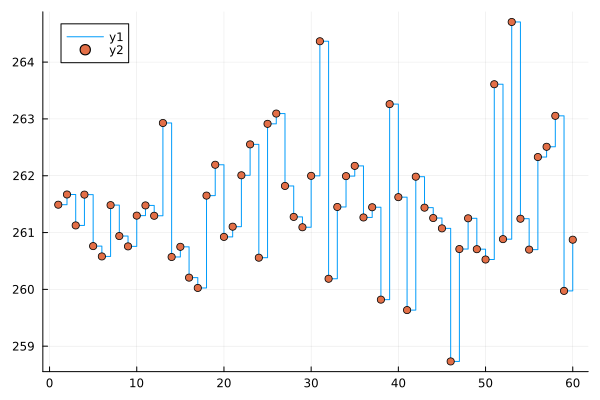

In [21]:
plot(samples_share_price[:,500], linetype=:steppost)
scatter!(samples_share_price[:,500])

### TODO: Sample Future Implied Volatility

In [97]:
volatility_data_df

0.07012021162304538

In [57]:
samples_IV = Normal(IVₒ,0.005) |> d -> rand(d, number_of_trading_periods, number_of_samples)
samples_IV[1,1:end] .= IVₒ;

60×1000 Matrix{Float64}:
 0.627397  0.627397  0.627397  0.627397  …  0.627397  0.627397  0.627397
 0.618483  0.618699  0.639632  0.64121      0.624466  0.637592  0.619122
 0.633791  0.635571  0.628715  0.631689     0.630796  0.620373  0.631787
 0.634858  0.628691  0.621142  0.636421     0.62928   0.624556  0.632222
 0.620017  0.626664  0.623392  0.624734     0.625622  0.636184  0.631002
 0.625754  0.631881  0.626554  0.632968  …  0.625971  0.631628  0.627503
 0.627969  0.628606  0.623343  0.630382     0.629275  0.61399   0.625122
 0.624208  0.621704  0.630133  0.635984     0.632593  0.632204  0.627976
 0.625351  0.627086  0.630455  0.627419     0.633224  0.628146  0.629036
 0.622313  0.635046  0.629672  0.623412     0.626134  0.631694  0.631142
 0.632857  0.621398  0.620941  0.626966  …  0.625829  0.636215  0.621677
 0.62207   0.633905  0.637241  0.624101     0.623031  0.627471  0.629886
 0.624205  0.637054  0.628849  0.616794     0.62633   0.624085  0.624681
 ⋮                        

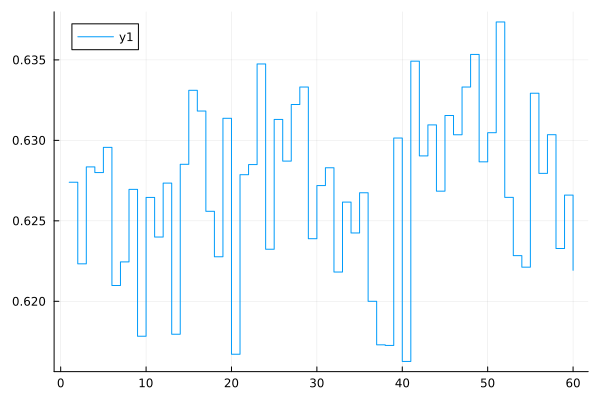

In [61]:
plot(samples_IV[:,500], linetype=:steppost)

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance.  Only risk capital that is not required for living expenses.

__You are fully responsible for any investment or trading decisions you make__. You should decide solely based on your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.